# Autosubmit profiler tests

This notebook contains the first tests performed with the new Autosubmit profiler.
The test scenarios listed here are described in [this issue][issue].

[issue]: https://earth.bsc.es/gitlab/es/autosubmit/-/issues/1120

## 1. A workflow configuration similar to what Dani used to profile memory issues

The configuration used by Daniel Beltran to profile memory issues in Autosubmit
configuration is based on this:

```yaml
EXPERIMENT:
    DATELIST: '20000101 20000102'
    MEMBERS: 'fc0 fc1'
    CHUNKSIZEUNIT: month
    CHUNK: '4'
    NUMCHUNKS: '400000' # 13000 max cap 1000000 jobs...
    CHUNKINI: ''
    CALENDAR: standard
    RUN_ONLY_MEMBERS: ''
```

Then we can change the amount of splits, or split and chunks, or just chunks.
Dani does that depending on which part he is trying to optimize.

### Steps to reproduce it

```bash
$ autosubmit expid -H local -d test -min
```

Open `~/autosubmit/<EXPID>/conf/minimal.yml`, set the project type to `LOCAL`,
and update the `LOCAL` project key accordingly:

```yaml
CONFIG:
  # Current version of Autosubmit.
  AUTOSUBMIT_VERSION: "4.0.87"
  # Total number of jobs in the workflow.
  TOTALJOBS: 20
  # Maximum number of jobs permitted in the waiting status.
  MAXWAITINGJOBS: 20
DEFAULT:
  # Job experiment ID.
  EXPID: "a003"
  # Default HPC platform name.
  HPCARCH: "local"
  #hint: use %PROJDIR% to point to the project folder (where the project is cloned)
  # Custom configuration location.
  CUSTOM_CONFIG: "%PROJDIR%/"
PROJECT:
  # Type of the project.
  PROJECT_TYPE: local
  # Folder to hold the project sources.
  PROJECT_DESTINATION: 'local_project'
PLATFORMS:
  LOCAL:
    TYPE: ps
    HOST: localhost
    PROJECT: 
    USER:
    QUEUE: debug
    SCRATCH_DIR: /tmp/
    ADD_PROJECT_TO_HOST: false
    MAX_WALLCLOCK: 48:00
    TEMP_DIR: ''
EXPERIMENT:
    DATELIST: '20000101 20000102'
    MEMBERS: 'fc0 fc1'
    CHUNKSIZEUNIT: month
    CHUNKSIZE: '4'
    NUMCHUNKS: '1' # 13000 max cap 1000000 jobs...
    CHUNKINI: ''
    CALENDAR: standard
    RUN_ONLY_MEMBERS: ''
LOCAL:
  PROJECT_PATH: '/tmp/project'
JOBS:
  TEST:
    FILE: TEMPLATE.sh
    RUNNING: once
```

Then run the profiler.

```bash
$ autosubmit create --profile -np <EXPID>
```

Then save the two files created in `~/autosubmit/<EXPID>/tmp/profile/`
to `./scenario1/`.

Now modify `EXPERIMENT.NUMCHUNKS` to `1000` and run the profiler again,
saving the new files to `./scenario1/` as well. Repeat it to `10000`,
`100000`, `1000000`, and `10000000`.

### Memory

In [1]:
from pathlib import Path

scenario_path = Path('./scenario1/')
result_files = sorted([result_file for result_file in scenario_path.iterdir() if result_file.is_file()])

if len(result_files) % 2 != 0:
    raise ValueError(f'Incorrect number of result files in {scenario_path}: {len(result_files)}')

cases = [1, 1000, 10000, 100000, 1000000, 10000000]
pairs = [(prof, txt) for prof, txt in zip(result_files[0::2], result_files[1::2])]
pair_cases = [(case, *pair) for case, pair in zip(cases, pairs)]

print(f'Processing {len(pair_cases)} test cases...')

Processing 6 test cases...


In [2]:
# %matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import re

MEM_REGEX = re.compile(r'MEMORY CONSUMPTION: (.*)')

def get_memory(txt):
    # memory
    with open(txt) as txt_file:
        m = MEM_REGEX.search(txt_file.read())
        # These are all in MiB.
        memory = float(m.group(1).strip(' .').split(' ')[0])
        return memory


memories = list(map(get_memory, [case[2] for case in pair_cases]))

In [4]:
print(cases)
print(memories)

[1, 1000, 10000, 100000, 1000000, 10000000]
[2.015625, 2.08203125, 2.7890625, 9.71484375, 79.29296875, 774.8515625]


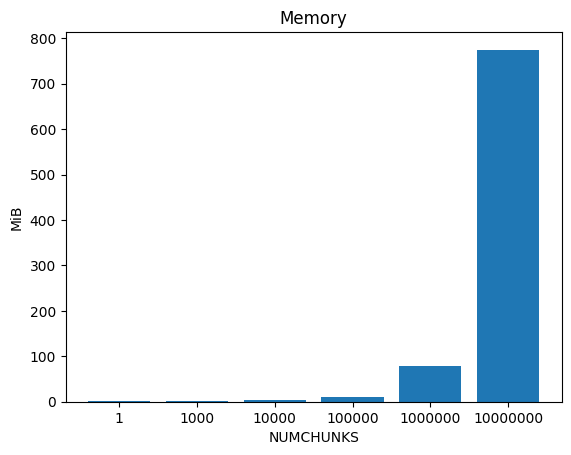

In [5]:
plt.bar(list(map(str, cases)), memories)
plt.title('Memory')
plt.ylabel('MiB')
plt.xlabel('NUMCHUNKS')
plt.show()

### cProfile

In [6]:
# There are 7 lines before the functions listing appears...
N=10

import pstats
import io
from IPython.display import display, Markdown

In [7]:
sort_by = pstats.SortKey.CUMULATIVE

def process_cumtime(prof):
    stream = io.StringIO()
    stats = pstats.Stats(str(prof), stream=stream)
    stats.strip_dirs().sort_stats(sort_by).print_stats()

    output = stream.getvalue()
    return '\n'.join(output.split('\n')[0:(N + 7)])

for case in pair_cases:
    header = f"## NUMCHUNKS={str(case[0])}"
    cprofile_truncated = process_cumtime(case[1])
    text = f"{header}\n```bash\n{cprofile_truncated}\n...\n```"
    display(Markdown(text))

## NUMCHUNKS=1
```bash
Tue Aug 22 13:34:57 2023    scenario1/a003_profile_20230822-133457.prof

         107526 function calls (104387 primitive calls) in 0.153 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.044    0.004    0.044    0.004 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.040    0.002    0.040    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.038    0.038 job_package_persistence.py:83(reset_table)
        2    0.000    0.000    0.029    0.015 job_list.py:178(generate)
        2    0.000    0.000    0.028    0.014 configcommon.py:1343(reload)
        2    0.000    0.000    0.028    0.014 job_list.py:2447(update_genealogy)
        1    0.000    0.000    0.026    0.026 db_structure.py:120(save_structure)
        4    0.000    0.000    0.024    0.006 constructor.py:116(get_single_data)
        2    0.000    0.000    0.023    0.011 configcommon.py:1391(load_last_run)
        1    0.000    0.000    0.022    0.022 experiment_history.py:191(process_status_changes)
...
```

## NUMCHUNKS=1000
```bash
Tue Aug 22 13:42:43 2023    scenario1/a003_profile_20230822-134243.prof

         107526 function calls (104387 primitive calls) in 0.150 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.044    0.004    0.044    0.004 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.041    0.002    0.041    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.038    0.038 job_package_persistence.py:83(reset_table)
        2    0.000    0.000    0.029    0.015 job_list.py:178(generate)
        2    0.000    0.000    0.028    0.014 job_list.py:2447(update_genealogy)
        1    0.000    0.000    0.027    0.027 db_structure.py:120(save_structure)
        2    0.000    0.000    0.026    0.013 configcommon.py:1343(reload)
        4    0.000    0.000    0.023    0.006 constructor.py:116(get_single_data)
        1    0.000    0.000    0.022    0.022 experiment_history.py:191(process_status_changes)
        2    0.000    0.000    0.021    0.011 configcommon.py:1391(load_last_run)
...
```

## NUMCHUNKS=10000
```bash
Tue Aug 22 13:43:11 2023    scenario1/a003_profile_20230822-134311.prof

         107526 function calls (104387 primitive calls) in 0.155 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.049    0.005    0.049    0.005 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.041    0.002    0.041    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.038    0.038 job_package_persistence.py:83(reset_table)
        2    0.000    0.000    0.029    0.015 job_list.py:178(generate)
        2    0.000    0.000    0.028    0.014 job_list.py:2447(update_genealogy)
        1    0.000    0.000    0.027    0.027 experiment_history.py:191(process_status_changes)
        1    0.000    0.000    0.026    0.026 db_structure.py:120(save_structure)
        2    0.000    0.000    0.026    0.013 configcommon.py:1343(reload)
        1    0.000    0.000    0.026    0.026 experiment_history.py:259(create_new_experiment_run)
        4    0.000    0.000    0.023    0.006 constructor.py:116(get_single_data)
...
```

## NUMCHUNKS=100000
```bash
Tue Aug 22 13:43:23 2023    scenario1/a003_profile_20230822-134323.prof

         107526 function calls (104387 primitive calls) in 0.149 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.043    0.004    0.043    0.004 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.036    0.002    0.036    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.035    0.035 job_package_persistence.py:83(reset_table)
        2    0.004    0.002    0.033    0.016 job_list.py:178(generate)
        2    0.000    0.000    0.030    0.015 configcommon.py:1343(reload)
        2    0.000    0.000    0.028    0.014 job_list.py:2447(update_genealogy)
        4    0.000    0.000    0.026    0.007 constructor.py:116(get_single_data)
        1    0.000    0.000    0.026    0.026 db_structure.py:120(save_structure)
        2    0.000    0.000    0.025    0.013 configcommon.py:1391(load_last_run)
        2    0.000    0.000    0.025    0.012 main.py:1059(load)
...
```

## NUMCHUNKS=1000000
```bash
Tue Aug 22 13:43:33 2023    scenario1/a003_profile_20230822-134333.prof

         107526 function calls (104387 primitive calls) in 0.177 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.035    0.018    0.065    0.032 job_list.py:178(generate)
       10    0.043    0.004    0.043    0.004 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.037    0.002    0.037    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.035    0.035 job_package_persistence.py:83(reset_table)
        2    0.000    0.000    0.028    0.014 job_list.py:2447(update_genealogy)
        2    0.000    0.000    0.027    0.013 configcommon.py:1343(reload)
        1    0.000    0.000    0.026    0.026 db_structure.py:120(save_structure)
        1    0.000    0.000    0.024    0.024 autosubmit.py:5833(load_job_list)
        4    0.000    0.000    0.023    0.006 constructor.py:116(get_single_data)
        2    0.000    0.000    0.022    0.011 configcommon.py:1391(load_last_run)
...
```

## NUMCHUNKS=10000000
```bash
Tue Aug 22 13:44:03 2023    scenario1/a003_profile_20230822-134403.prof

         107526 function calls (104387 primitive calls) in 0.545 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.366    0.183    0.397    0.198 job_list.py:178(generate)
        1    0.000    0.000    0.167    0.167 autosubmit.py:5833(load_job_list)
       10    0.050    0.005    0.050    0.005 {method 'commit' of 'sqlite3.Connection' objects}
       20    0.041    0.002    0.041    0.002 {method 'execute' of 'sqlite3.Cursor' objects}
        1    0.000    0.000    0.038    0.038 job_package_persistence.py:83(reset_table)
        2    0.000    0.000    0.037    0.019 subprocess.py:332(call)
        2    0.000    0.000    0.034    0.017 subprocess.py:732(__init__)
        1    0.000    0.000    0.034    0.034 autosubmit.py:4263(database_backup)
        2    0.000    0.000    0.034    0.017 subprocess.py:1550(_execute_child)
        2    0.000    0.000    0.029    0.014 job_list.py:2447(update_genealogy)
...
```

### Notes

WIP